# New York City: SAT Results, 2016

<br></br>
<i>The Scholastic Aptitude Test (SAT) is an exam U.S. high school students take before applying to college. The SAT consists of three sections, each with 800 possible points, making 2,400 the highest possible combined score. Colleges factor SAT scores when deciding who to admit. Organizations often rank high schools by their average SAT scores. High average SAT scores are usually indicative of a good school. The scores are also considered a measure of overall school district quality.
    
SAT's fairness to marginalized groups is a controversial issue in US education. Investigating correlations between SAT scores and key demographic factors requires a dive into big societal issues concerning race, gender, and wealth gap (to name a few).</i>

## 1. Dataset

New York City makes its [data on high school SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) available online, as well as the demographics for each high school. Here are the datasets used in this notebook:

| Source | File(s) | Description |
| :--- | :--- | :--- |
| [Scores by School](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) | sat_results.csv | SAT scores for each high school in New York City
| [School Attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) | (no file) | Attendance information for each school in New York City
| [Class Size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) | class_size.csv | Information on class size for each school
| [AP Test Result](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) | ap_2010.csv | **Advanced Placement (AP)** exam results for each high school; passing an optional AP exam in a particular subject can earn a student college credit in that subject
| [Graduation Outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) | graduation.csv | The percentage of students who graduated, and other outcome information
| [Demographics and Directory](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) | demographics.csv, hs_directory.csv | Demographic information for each school; a directory of high schools
| [School Survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) | survey_all.txt, survey_d75.txt | Surveys of parents, teachers, and students at each school

Some notes prior to reading the datasets:

- Although the total SAT score has changed a few times, score datasets for this project is based on a 2,400 total. 
- Each school in New York City has a unique code called a district borough number, or DBN.
- New York City schools fall within several different school districts. Aggregating data by district allows mapping data to plot district-by-district differences.
- Since only high school students take the SAT, certain data sets need to be cleaned to only include high schools.
- New York City has a significant immigrant population, which makes it one of the most diverse in the country. Because of this, there is usually enough data to compare or correlate demographic factors such as race, income, and gender with SAT scores. The NYC SAT scores may provide enough data to unearth biases in SAT.

## 2. Preparing the Data

To arrive at the final `combined` dataframe in the [data analysis notebook](http://localhost:8888/notebooks/Projects/Data/Dataquest/dq-notebooks/exercises/DQ2630_NYC_SAT_Data_Cleaning.ipynb), most of the code needs to be replicated. This includes the code under the following sections:

- Reading the Data 
- Cleaning the Data
- Combining the Data

### 2.1 Reading the Data

The datasets that make up the final dataframe are either stored as .csv or .json file. The .csv files are handled first, then the JSON files. All CSV files are saved as pandas dataframes, and stored in a dictionary, `d`. The two JSON files are combined into one dataframe called `survey`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

d = {}
data_files = ['ap_2010.csv'
    , 'class_size.csv'
    , 'demographics.csv'
    , 'graduation.csv'
    , 'hs_directory.csv'
    , 'sat_results.csv'
]

# read csv files
for f in data_files:
    file = pd.read_csv('datasets/schools/{}'.format(f))
    d[f.replace('.csv', '')] = file
    
# read survey files
all_survey = pd.read_csv('datasets/schools/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('datasets/schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort=False)

### 2.2 Cleaning the Data

The data cleaning involves creating `DBN` columns for the dataframes that has a lowercase `dbn` column (like in the case of `survey` and `hs_directory`), or doesn't have a `DBN` column, but has columns that can be used to create one (like in the case of `class_size`). In addition, a total `sat_score` is created in `sat_results` for high-level analysis. Latitude and longtitude pairs are also created in `hs_directory` to allow for geographic clustering, particularly in a district-level.

Most of the datasets also have columns that are adding to the bulk, but provide little value for analysis. For instance, after consolidation, `survey` has over 2,000 columns, most of which need to be dropped. Finally, some columns need to be converted to numeric format, such as `AP Test Takers`, `Total Exams Taken`, and `Number of Exams with scores 3 4 or 5` in `ap_2010`.

In [2]:
# filter survey columns
survey['DBN'] = survey['dbn']
survey_fields = ['DBN', 'rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 
                 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 
                 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 
                 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 
                 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']
survey = survey[survey_fields]
d['survey'] = survey

# insert DBN fields
d['hs_directory']['DBN'] = d['hs_directory']['dbn']

def fill_num(n):
    if len(str(n)) == 2:
        return str(n)
    else:
        return str(n).zfill(2)
    
d['class_size']['padded_csd'] = d['class_size']['CSD'].apply(fill_num)
d['class_size']['DBN'] = d['class_size']['padded_csd'] + d['class_size']['SCHOOL CODE']

# combine SAT scores
sats = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for s in sats:
    d['sat_results'][s] = pd.to_numeric(d['sat_results'][s], errors='coerce')
d['sat_results']['sat_score'] = d['sat_results'][sats[0]] + d['sat_results'][sats[1]] + d['sat_results'][sats[2]]

# parse geographic coordinates
def find_lat(loc):
    c = re.findall('\(.+, .+\)', loc)
    lat = c[0].split(',')[0].replace('(','')
    return lat

def find_lon(loc):
    c = re.findall('\(.+, .+\)', loc)
    lon = c[0].split(',')[1].replace(')','').strip()
    return lon

d['hs_directory']['lat'] = d['hs_directory']['Location 1'].apply(find_lat)
d['hs_directory']['lon'] = d['hs_directory']['Location 1'].apply(find_lon)
d['hs_directory']['lat'] = pd.to_numeric(d['hs_directory']['lat'], errors='coerce')
d['hs_directory']['lon'] = pd.to_numeric(d['hs_directory']['lon'], errors='coerce')

# condense class_size, demographics, and graduation
class_size = d['class_size']
class_size = class_size[(class_size['GRADE '] == '09-12') & (class_size['PROGRAM TYPE'] == 'GEN ED')]
class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace=True)

d['class_size'] = class_size
d['demographics'] = d['demographics'][d['demographics']['schoolyear'] == 20112012]
d['graduation'] = d['graduation'][d['graduation']['Cohort'] == '2006']
d['graduation'] = d['graduation'][d['graduation']['Demographic'] == 'Total Cohort']

# convert AP Scores
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for c in cols:
    d['ap_2010'][c] = pd.to_numeric(d['ap_2010'][c], errors='coerce')

### 2.3 Combining the Data

The last step in preparing the data is merging all the datasets. For this step, a bunch of left and inner joins need to be completed to preserve as much data as possible. For imperfect matches, these joins lead to rows with missing data, which have been imputed with either the mean or 0.

In [3]:
# perform left and inner joins
combined = d['sat_results']
combined = combined.merge(d['ap_2010'], on='DBN', how='left')
combined = combined.merge(d['graduation'], on='DBN', how='left')
to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']
for m in to_merge:
    combined = combined.merge(d[m], on='DBN', how='inner')
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# add a school district column for mapping
def extract_distric(n):
    return n[:2]

combined['school_dist'] = combined['DBN'].apply(extract_distric)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01


## 3. Analyzing and Visualizing the Data

Now that `combined` has been generated, it can be used to derive a `correlations` dataframe, which can surface relationships between demographic factors. 

In [4]:
# remove DBN since it's not a useful numerical value for correlation
survey_fields.remove('DBN')

In [5]:
# create dataframe for SAT score correlations
com_corr = combined.corr()
sat_corr = com_corr['sat_score'].round(2)
sat_corr.sort_values(ascending=False)[:34]

sat_score                               1.00
SAT Critical Reading Avg. Score         0.99
SAT Writing Avg. Score                  0.99
SAT Math Avg. Score                     0.97
white_per                               0.62
asian_per                               0.57
AP Test Takers                          0.52
Total Exams Taken                       0.51
asian_num                               0.48
Number of Exams with scores 3 4 or 5    0.46
white_num                               0.45
N_s                                     0.42
N_p                                     0.42
total_students                          0.41
female_num                              0.39
NUMBER OF STUDENTS / SEATS FILLED       0.39
AVERAGE CLASS SIZE                      0.38
total_enrollment                        0.37
NUMBER OF SECTIONS                      0.36
saf_s_11                                0.34
aca_s_11                                0.34
male_num                                0.33
Total Coho

In [6]:
sat_corr.sort_values(ascending=False)[34:]

number_programs                   0.12
female_per                        0.11
eng_tot_11                        0.10
com_t_11                          0.08
com_tot_11                        0.08
rr_p                              0.05
CSD                               0.04
aca_p_11                          0.04
eng_t_11                          0.04
hispanic_num                      0.03
sped_num                          0.03
black_num                         0.03
eng_p_11                          0.02
rr_t                             -0.02
zip                              -0.06
male_per                         -0.11
lat                              -0.12
com_p_11                         -0.12
lon                              -0.13
ell_num                          -0.15
black_per                        -0.28
ell_percent                      -0.40
hispanic_per                     -0.40
sped_percent                     -0.45
frl_percent                      -0.72
SCHOOLWIDE PUPIL-TEACHER 

These are some key takeaways from these `sat_score` correlations:

- **Enrollment**. (`total_enrollment`) has a strong positive correlation with `sat_score`, which indicates that larger schools tend to do better on the SAT. This is somewhat surprising because smaller schools — where students generally receive more individualized assistance — logically should have higher scores. Other proxies for enrollment correlate similarly. These include `total_students`, `N_s`, `N_p`, `N_t`, `AP Test Takers`, `Total Exams Taken`, and `NUMBER OF SECTIONS`.
- **Section Scores**. Unsurprisingly, `SAT Critical Reading Avg. Score`, `SAT Math Avg. Score`, and `SAT Writing Avg. Score` are very strongly correlated.
- **Race**. Strong racial correlations can be seen in the set above. For instance, white (`white_per`) and Asian (`asian_per`) populations correlate positively. On the other hand, although not as strongly, black (`black_per`) and latino (`hispanic_per`) populations correlate negatively.
- **Gender**. Both the percentage of females (`female_per`) and number of females (`female_num`) at a school correlate positively with SAT score, whereas the percentage of males (`male_per`) and the number of males (`male_num`) correlate negatively. This could indicate that women do better on the SAT than men.
- **Safety**. Teacher and student ratings of school safety (`saf_t_11`, and `saf_s_11`) correlate with `sat_score`, but the parents' (`saf_p_11`) ratings do not correlate as well.
- **Ratings**. Student ratings of school academic standards (`aca_s_11`) correlate with `sat_score`, but this does not hold for ratings from teachers and parents (`aca_p_11` and `aca_t_11`).
- **ELL and FRL**. The percentage of English language learners (`ell_percent`) and the free and reduced lunch group (`frl_percent`) have strong negative correlations with SAT scores.

### 3.1. Safety and SAT Scores

The columns `saf_t_11` and `saf_s_11`, which measure perceived safety at school by teachers and students respectively, both correlate highly with `sat_score`. The plots below visualize these correlations.

In [7]:
# set SAT defaults
sat = 'sat_score'
sat_label = 'SAT Score'
sat_ticks = np.arange(800, 2400, 200)

# set Student Safety defaults
saf_s = 'saf_s_11'
saf_s_label = 'Student Safety Score'
saf_s_ticks = np.arange(4.5, 9.5, 0.5)

# set Teacher Safety defaults
saf_t = 'saf_t_11'
saf_t_label = 'Teacher Safety Score'
saf_t_ticks = np.arange(4.5, 9.5, 0.5)

# plot defaults
figsize = (16, 5)
hline = '#cdcdcd'

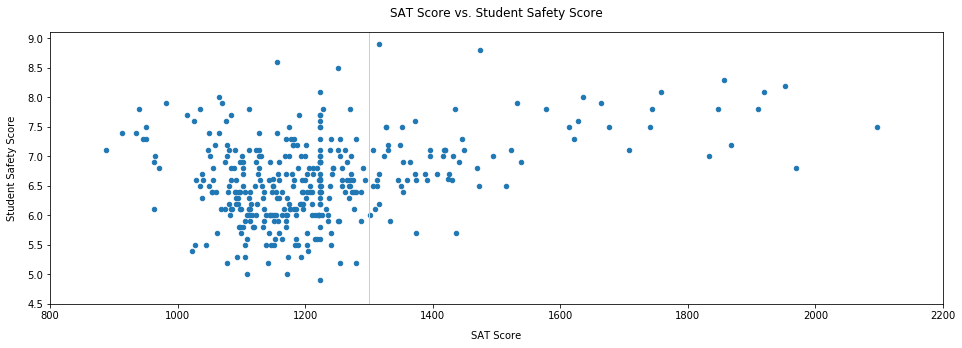

In [8]:
# plot SAT score vs. student safety score
combined.plot.scatter(x = sat, y = saf_s, figsize = figsize)
plt.title('{} vs. {}'.format(sat_label, saf_s_label), pad = 15)
plt.axvline(x = 1300, linewidth = 1, color = hline)
plt.xlabel(sat_label, labelpad = 10)
plt.ylabel(saf_s_label, labelpad = 10)
plt.xticks(sat_ticks)
plt.yticks(saf_s_ticks)
plt.show()

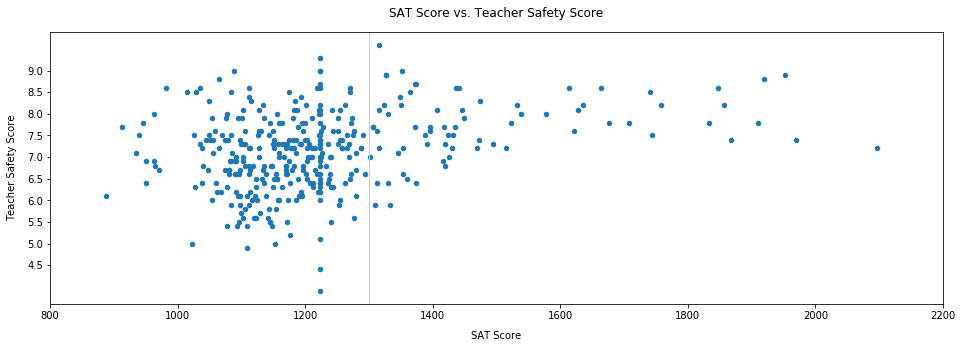

In [9]:
# plot SAT score vs. teacher safety score
combined.plot.scatter(x = sat, y = saf_t, figsize = figsize)
plt.title('{} vs. {}'.format(sat_label, saf_t_label), pad = 15)
plt.axvline(x = 1300, linewidth = 1, color = hline)
plt.xlabel(sat_label, labelpad = 10)
plt.ylabel(saf_t_label, labelpad = 10)
plt.xticks(sat_ticks)
plt.yticks(saf_t_ticks)
plt.show()

The two charts above appear to behave the same way. On both, there seems to be two distinct sections: those with `sat_score` values under 1300, where the safety (`saf_s_11` and `saf_t_11`) values appear to be well dispersed, making the correlation weaker; and those above 1300, where there seems to be a more defined progression of safety values relative to the SAT score.

To review, here are the borough-level aggregate values for SAT scores, student safety score, and teacher safety scores:

In [10]:
tenths = lambda x: round(x, 1)
saf_cols = ['boro', 'sat_score', 'saf_s_11', 'saf_t_11']
dist_saf = combined.loc[:,saf_cols].groupby('boro').agg(np.mean).apply(tenths)
dist_saf.T

boro,Bronx,Brooklyn,Manhattan,Queens,Staten Island
sat_score,1157.6,1181.4,1278.3,1286.8,1382.5
saf_s_11,6.6,6.4,6.8,6.7,6.5
saf_t_11,7.0,7.0,7.3,7.4,7.2


Based on the summary above, the differences in safety scores across boroughs are not too significant. The safety score from students range from 6.4 to 6.8 — just almost a half-point difference. The same pattern can be seen in teacher safety scores, which range form 7.0 to 7.4. 

Because of these miniscule differences in values, it may be helpful to investigate correlations using these district values to surface correlations. The results are as follows:

In [11]:
# correlate district-level values
dist_saf.corr().apply(tenths)

,sat_score,saf_s_11,saf_t_11
sat_score,1.0,0.2,0.7
saf_s_11,0.2,1.0,0.7
saf_t_11,0.7,0.7,1.0


In [12]:
# correlate school-level values
combined.loc[:,saf_cols].corr().apply(tenths)

,sat_score,saf_s_11,saf_t_11
sat_score,1.0,0.3,0.3
saf_s_11,0.3,1.0,0.6
saf_t_11,0.3,0.6,1.0


It is very interesting to see that the correlation of SAT scores and student safety scores weaken, while the SAT sores and teacher safety scores significantly increase, when rolled up to the district level.

This suggests that on a district-wide scale, teachers' gauge of safety — and by extension, school locations —  strongly correlates with SAT scores. To further investigate the relationships between teacher safety scores, districts, and SAT scores, below is a breakdown of the same plotting, split by borough.

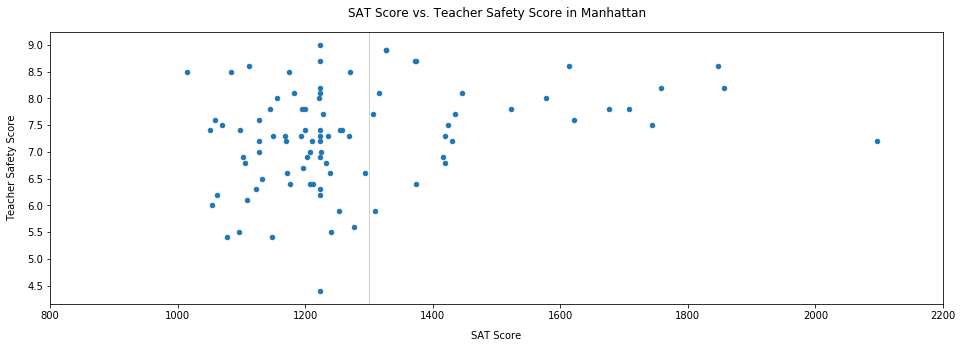

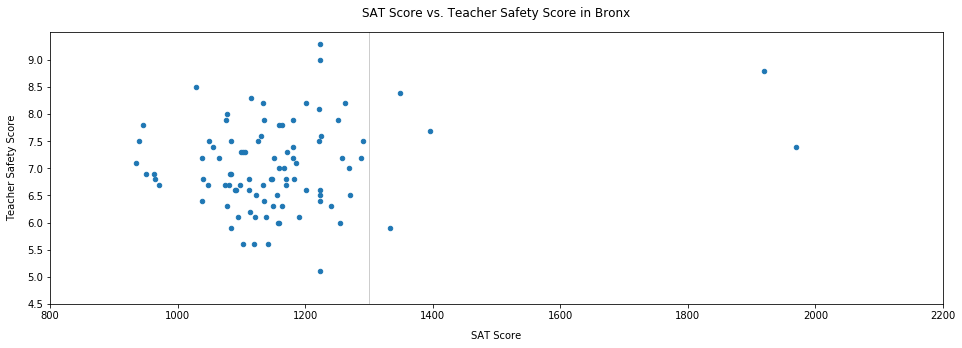

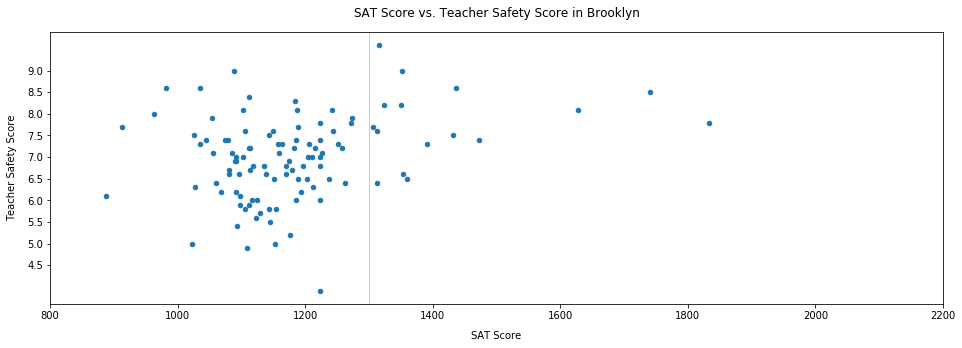

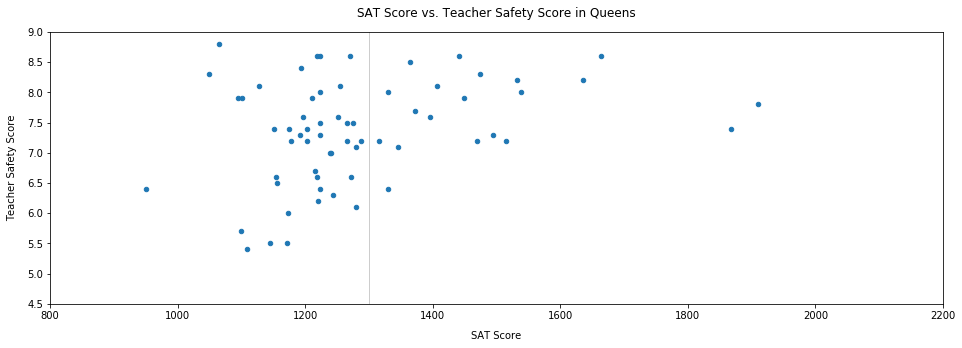

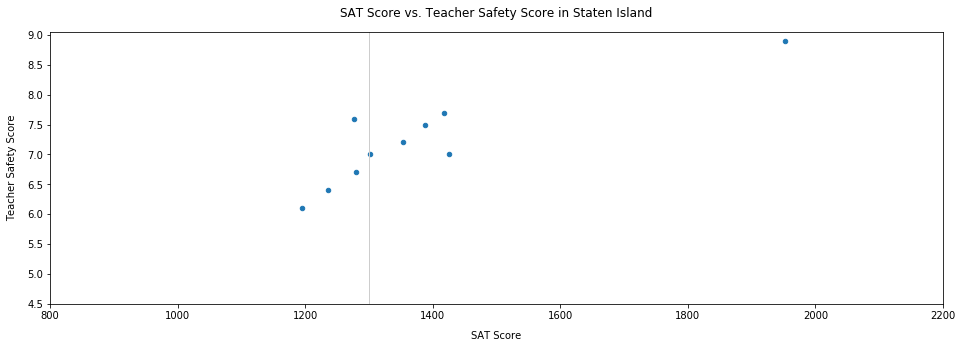

In [13]:
boros = list(combined['boro'].unique())

# plot by borough to see if correlation changes
for boro in boros:
    df = combined[combined['boro'] == boro]
    df.plot.scatter(x = sat, y = saf_t, figsize = figsize)
    plt.title('{} vs. {} in {}'.format(sat_label, saf_t_label, boro), pad = 15)
    plt.axvline(x = 1300, linewidth = 1, color = hline)
    plt.xlabel(sat_label, labelpad = 10)
    plt.ylabel(saf_t_label, labelpad = 10)
    plt.xticks(sat_ticks)
    plt.yticks(saf_t_ticks)
    plt.show()

All five boroughs seem to confirm to the general correlation pattern established earlier. After the 1300 SAT mark, the relationship between SAT score and teachers' security index becomes much more pronounced. Out of the five boroughs, Staten Island (despite having the least number of values) demonstrates the clearest connection between the two factors.

### 3.3 Exploring Race and SAT Scores

There are a few columns that indicate the percentage of each race at a given school. By plotting out the correlations between these columns and `sat_score`, it may be possible to surface any racial differences in SAT performance. These columns are as follows:

- `white_per`
- `asian_per`
- `black_per`
- `hispanic_per`

In [14]:
race_sat_cols = ['sat_score', 'white_per', 'asian_per', 'black_per', 'hispanic_per']
race_sat = combined.loc[:,race_sat_cols].corr()
race_sat.iloc[:,0]

sat_score       1.000000
white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

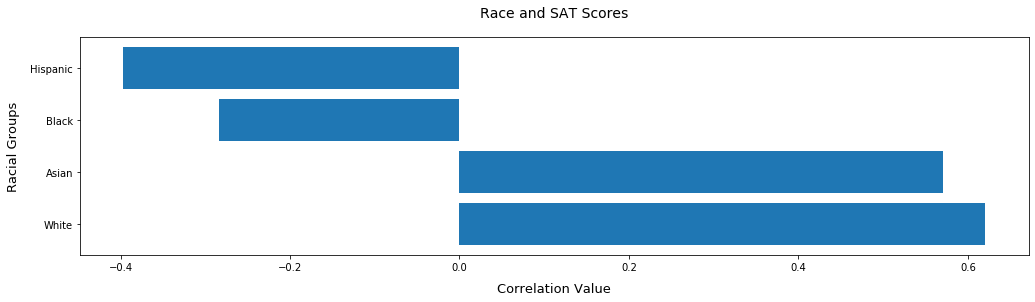

In [15]:
bar_widths = race_sat['sat_score'].values[1:]

races = []
for r in race_sat_cols:
    x = r.replace('_per','').title()
    races.append(x)

fig,ax = plt.subplots(figsize=(17,4))
ax.barh(races[1:], bar_widths, 0.8)
ax.set_xlabel('Correlation Value', fontsize=13, labelpad=10)
ax.set_ylabel('Racial Groups', fontsize=13, labelpad=10)
plt.title('Race and SAT Scores', fontsize=14, pad=20)            
plt.show()

The chart above reaffirms the initial observation about correlations SAT scores and various racial groups. There seems to be a positive correlation between SAT and White and Asian students, while the opposite is true for Black and Hispanic students.

To provide more context in this relationship, it may be helpful to zoom out a bit and look at the issue at hand from a different angle. For instance, `frl_percent`, which refers to the percentage of the population of free lunch, seems to show an inverse relationship with the same set of racial groups. It has a negative correlation with White and Asian students, while having a positive correlation between Black and Hispanic students. The correlation table is below.

In [16]:
race_frl_cols = ['frl_percent', 'white_per', 'asian_per', 'black_per', 'hispanic_per', 'sat_score']
race_frl_corr = combined.loc[:,race_frl_cols].corr()
race_frl_corr.iloc[[0,5],1:5]

,white_per,asian_per,black_per,hispanic_per
frl_percent,-0.722343,-0.383266,0.066348,0.571657
sat_score,0.620718,0.570730,-0.284139,-0.396985


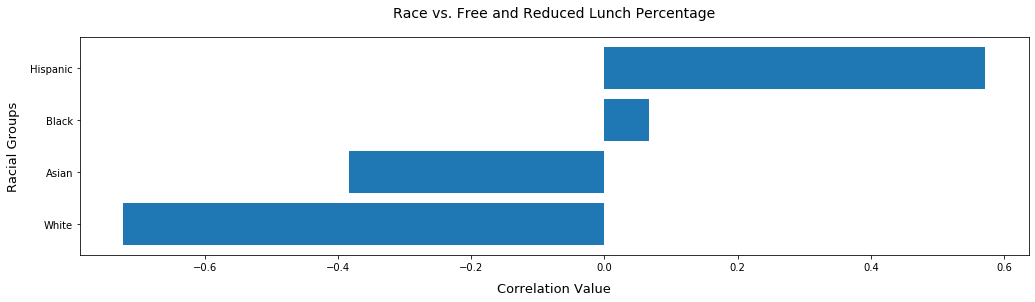

In [17]:
frl_cols = ['frl_percent', 'white_per', 'asian_per', 'black_per', 'hispanic_per']
race_frl = combined.loc[:,frl_cols].corr()
bar_widths = race_frl['frl_percent'].values[1:]

races = []
for r in frl_cols:
    x = r.replace('_per','').title()
    races.append(x)

fig,ax = plt.subplots(figsize=(17,4))
ax.barh(races[1:], bar_widths, 0.8)
ax.set_xlabel('Correlation Value', fontsize=13, labelpad=10)
ax.set_ylabel('Racial Groups', fontsize=13, labelpad=10)
plt.title('Race vs. Free and Reduced Lunch Percentage', fontsize=14, pad=20)            
plt.show()

Since there are [income eligibility requirements](http://www.cn.nysed.gov/common/cn/files/attiincomeeligibilitygdlns.pdf) for Free and Reduced Lunch, this implies that students who qualify for it usually belong to very poor households. Looking at it through this lens, the data suggests that relationships between SAT scores and race may be compounded — if not driven — by economic factors. 

For instance, hispanic students, who may deal with more financial roadblocks, tend to have lower scores. On the other hand, white students, who tend to have more economic freedom also tend to do better in SAT scores.

### 3.4 Exploring Gender and SAT Scores

Similar to explorations in race, correlations between each gender percentage and `sat_score` can also be surfaced. There are two columns that indicate the percentage of each gender at a school:

- `male_per`
- `female_per`

The list and the plotting for these correlations can be found below.

In [18]:
gender_cols = ['sat_score', 'male_per', 'female_per']
gender_sat = combined.loc[:,gender_cols].corr()
gender_sat.iloc[:,0]

sat_score     1.000000
male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64

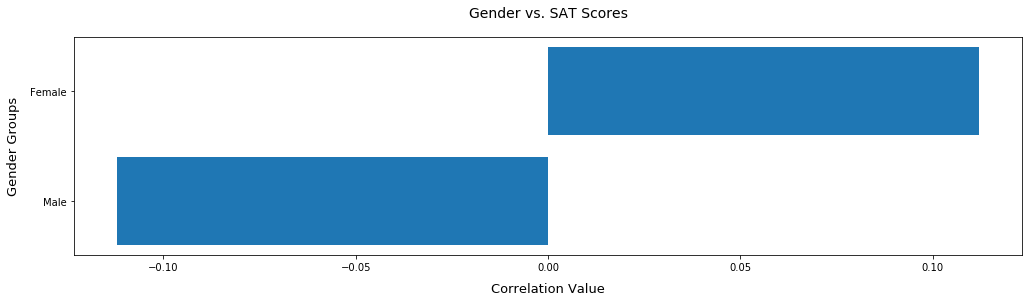

In [19]:
bar_widths = gender_sat['sat_score'].values[1:]

genders = []
for g in gender_cols:
    x = g.replace('_per','').title()
    genders.append(x)

fig,ax = plt.subplots(figsize=(17,4))
ax.barh(genders[1:], bar_widths, 0.8)
ax.set_xlabel('Correlation Value', fontsize=13, labelpad=10)
ax.set_ylabel('Gender Groups', fontsize=13, labelpad=10)
plt.title('Gender vs. SAT Scores', fontsize=14, pad=20)            
plt.show()

In [20]:
# get correlation of gender and SAT in male-dominated high schools
combined[combined['male_per'] > 50.0].loc[:,gender_cols].corr().round(3)['sat_score']

sat_score     1.000
male_per     -0.021
female_per    0.021
Name: sat_score, dtype: float64

In [21]:
# get correlation of gender and SAT in female-dominated high schools
combined[combined['female_per'] > 50.0].loc[:,gender_cols].corr().round(3)['sat_score']

sat_score     1.000
male_per     -0.099
female_per    0.099
Name: sat_score, dtype: float64

The data suggests that, there is a negative correlation between male and SAT scores and there is a positive correlation between female and SAT scores. However, both correlations are weak. Even when the dataset has been filtered to only include male-dominated schools or female-dominated schools, the correlations still do not appear significant.

### 3.5 Exploring AP Scores vs. SAT Scores

Advanced Placement (AP) exams are taken by high school students to earn college credit. This allows students to fast track the completion of their college degrees. AP exams usually require a higher level of mastery in a specific subject, often more advanced than a general high school curriculum.

Because of this, it seems logical to infer that the number of students taking AP exams is highly correlated with the school's SAT scores. To flatten discrepancies caused by differences in `total_enrollment`, the table and plotting below use the percentage (`ap_per`) of students in each school who has taken at least one AP exam.

In [22]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

ap_cols = ['sat_score', 'ap_per']
combined[ap_cols].corr()

,sat_score,ap_per
sat_score,1.000000,0.057171
ap_per,0.057171,1.000000


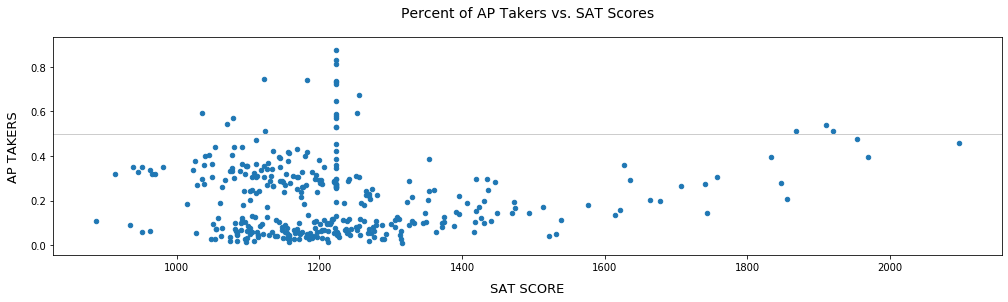

In [23]:
combined.plot.scatter(x='sat_score', y='ap_per', figsize=(17,4))
plt.title('Percent of AP Takers vs. SAT Scores', fontsize=14, pad=20)
plt.axhline(y = 0.5, linewidth = 1, color = hline)
plt.xlabel('SAT Score'.upper(), fontsize=13, labelpad=10)
plt.ylabel('AP Takers'.upper(), fontsize=13, labelpad=10)
plt.show()

In [24]:
# get correlation of AP Takers and SAT in schools 
# where more than half of the population took at least one AP exam
combined[combined['ap_per'] > 0.5].loc[:,ap_cols].corr().round(3)['sat_score']

sat_score    1.000
ap_per      -0.329
Name: sat_score, dtype: float64

In [25]:
# get correlation of AP Takers and SAT in schools
# where half or less than half of the population took at least one AP exam
combined[combined['ap_per'] <= 0.5].loc[:,ap_cols].corr().round(3)['sat_score']

sat_score    1.000
ap_per       0.028
Name: sat_score, dtype: float64

Based on the data above, it seems that the percentage of AP takers tend to negatively impact SAT scores, contrary to the initial hypothesis.